In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

In [51]:
df_month_data = pd.read_csv("Cst_to_M.csv",index_col=False,encoding="utf-8")
alpha = 0.9
destination = 'Malmö Godsbangård'

In [52]:
def create_adjacency_matrix(df, destination_station=None):
    """
    Create an adjacency matrix from travel records
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records
    destination_station (str, optional): Final destination station to exclude
    
    Returns:
    pandas.DataFrame: Adjacency matrix of stations
    """
    # Extract all stations except the destination station
    all_departure_stations = set(df['Avgångsplats'])
    all_arrival_stations = set(df['Ankomstplats'])
    
    # Combine all stations and remove destination station if specified
    all_stations = list(all_departure_stations.union(all_arrival_stations))
    if destination_station in all_stations:
        all_stations.remove(destination_station)
    
    # Create empty adjacency matrix
    n = len(all_stations)
    init_matrix = np.full((n, n), 0)
    adj_matrix = pd.DataFrame(init_matrix,
                              index=all_stations, columns=all_stations)
    
    # Fill adjacency matrix
    for _, row in df.iterrows():
        dep_station = row['Avgångsplats']
        arr_station = row['Ankomstplats']
        
        # Skip connections involving the destination station
        if dep_station == destination_station or arr_station == destination_station:
            continue
        
        # Mark connection between departure and arrival stations
        if dep_station in all_stations and arr_station in all_stations:
            adj_matrix.loc[dep_station, arr_station] = 1
    
    return adj_matrix,all_stations

In [53]:
def plot_adjacency_matrix(adj_matrix, station_names):
    """
    Plot the adjacency matrix using seaborn heatmap.
    
    Parameters:
    adj_matrix (numpy.ndarray): The adjacency matrix
    station_names (list): List of station names
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(adj_matrix, cmap='Blues', 
                xticklabels=station_names, 
                yticklabels=station_names,
                linewidths=0.5,
                linecolor='lightgray')
    plt.title('Station Connectivity Adjacency Matrix')
    plt.xlabel('To Station')
    plt.ylabel('From Station')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

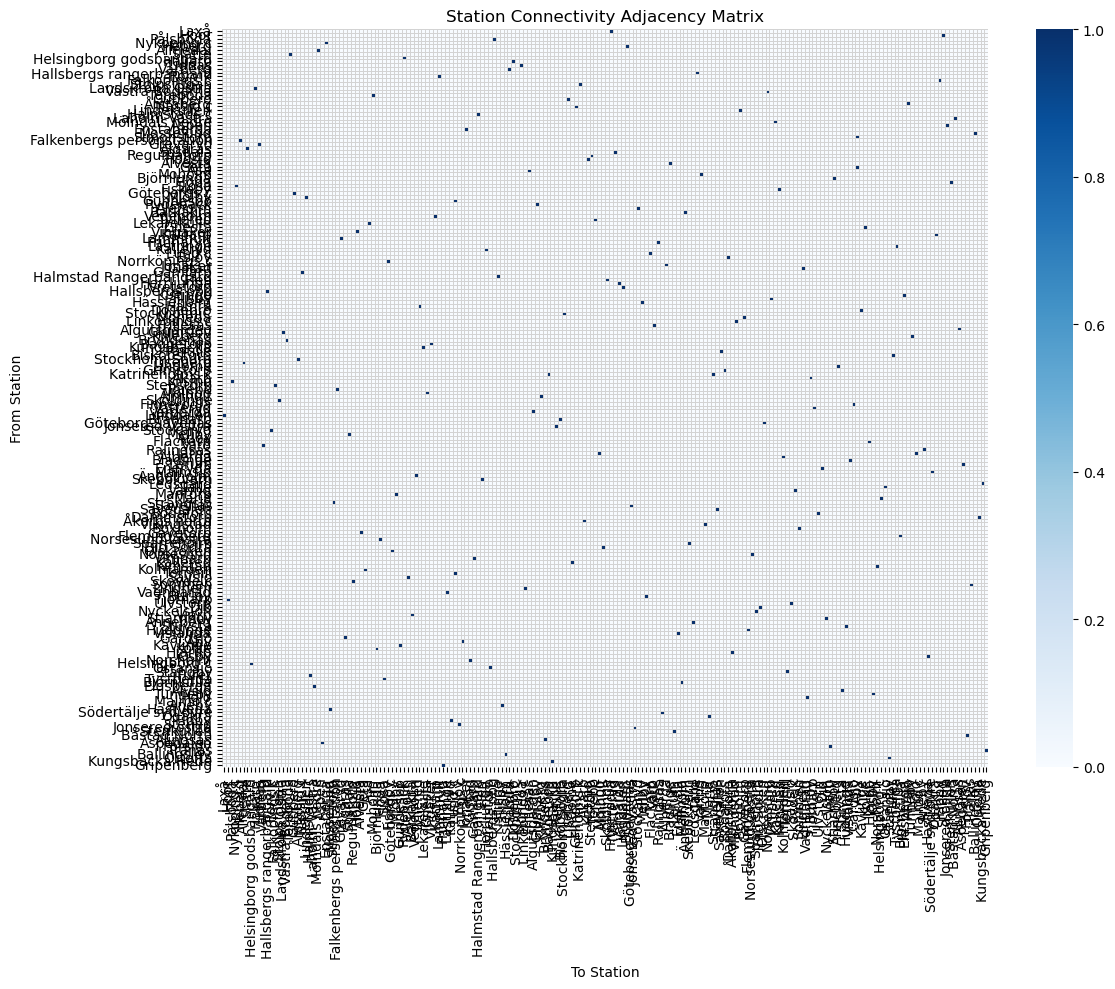

In [54]:
adj_max, all_stations = create_adjacency_matrix(df_month_data,destination)
plot_adjacency_matrix(adj_max, all_stations)

In [55]:
def create_delay_adjacency_matrix(df, adjacency_matrix, destination_station):
    """
    Create a delay adjacency matrix and vector based on an existing adjacency matrix
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing travel records with 'AvgFörsening' column
    adjacency_matrix (pandas.DataFrame): Existing adjacency matrix showing connected stations
    destination_station (str): Final destination station
    
    Returns:
    tuple: (delay_matrix, delay_vector)
        - delay_matrix: pandas.DataFrame with average delays between adjacent stations
        - delay_vector: pandas.Series with average delays between stations and destination
    """
    # Get the list of stations (excluding destination)
    stations = adjacency_matrix.index.tolist()
    
    init_delay_matrix = np.full((len(stations), len(stations)), np.inf)
    # np.fill_diagonal(init_delay_matrix, 10)
    # Create empty delay matrix with same dimensions as adjacency matrix
    delay_matrix = pd.DataFrame(init_delay_matrix,
                               index=stations, columns=stations)
    
    # Create delay vector for connections to destination
    init_delay_vector = np.full(len(stations), np.inf)
    delay_vector = pd.Series(init_delay_vector, index=stations)
    
    # Fill delay matrix for adjacent stations
    for i, stationi in enumerate(stations):
        for j, stationj in enumerate(stations):
            # Check if stations are adjacent according to adjacency matrix
            if adjacency_matrix.loc[stationi, stationj] == 1:
                # Get records for travels between these stations
                station_travels = df[(df['Avgångsplats'] == stationi) & 
                                    (df['Ankomstplats'] == stationj)]
                
                if not station_travels.empty:
                    # Calculate average delay for this connection
                    df_filtered_travels = station_travels[station_travels['AvgFörsening'] > alpha]
                    # df_filtered_travels['AvgFörsening'] = df_filtered_travels['AvgFörsening'].apply(lambda x: max(0, x))
                    avg_delay = df_filtered_travels['AvgFörsening'].mean()
                    delay_matrix.loc[stationi, stationj] = avg_delay
    
    # Fill delay vector for connections to destination
    for station in stations:
        # Get records for travels between station and destination
        destination_travels = df[(df['Avgångsplats'] == station) & 
                                (df['Ankomstplats'] == destination_station)]
        
        if not destination_travels.empty:
            # Calculate average delay for this connection to destination
            df_filtered_travels = destination_travels[destination_travels['AvgFörsening'] > alpha]
            avg_delay = df_filtered_travels['AvgFörsening'].mean()
            delay_vector[station] = avg_delay
    
    return delay_matrix, delay_vector

In [14]:
def plot_combined_delay_analysis(delay_matrix, delay_vector, destination_station, figsize=(16, 12)):
    """
    Create a combined visualization with both delay matrix and vector
    
    Parameters:
    delay_matrix (pandas.DataFrame): Matrix containing average delays between stations
    delay_vector (pandas.Series): Vector containing average delays to destination
    destination_station (str): Name of the destination station
    figsize (tuple): Figure size as (width, height)
    
    Returns:
    matplotlib.figure.Figure: The figure object containing the plots
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the delay matrix on the first subplot
    plt.sca(ax1)
    plot_matrix = delay_matrix.copy().replace(0, np.nan)
    sns.heatmap(plot_matrix, 
                cmap=sns.color_palette("YlOrRd", as_cmap=True),
                annot=True,
                fmt=".1f",
                linewidths=0.5,
                square=True,
                mask=plot_matrix.isna(),
                cbar_kws={'label': 'Average Delay (minutes)'})
    plt.title(f'Delay Matrix Between Stations', fontsize=16, pad=20)
    plt.xlabel('Arrival Station', fontsize=12, labelpad=10)
    plt.ylabel('Departure Station', fontsize=12, labelpad=10)
    plt.xticks(rotation=45, ha='right')
    
    # Plot the delay vector on the second subplot
    plt.sca(ax2)
    plot_vector = delay_vector[delay_vector > 0].sort_values(ascending=False)
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(plot_vector)))
    ax2.barh(plot_vector.index, plot_vector.values, color=colors)
    
    # Add value labels
    for i, v in enumerate(plot_vector.values):
        ax2.text(v + 0.1, i, f'{v:.1f}', va='center')
    
    plt.title(f'Average Delays to {destination_station}', fontsize=16, pad=20)
    plt.xlabel('Average Delay (minutes)', fontsize=12)
    plt.ylabel('Departure Station', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

In [56]:
delayed_adjacent_matrix, delayed_vector = create_delay_adjacency_matrix(df_month_data, adj_max, destination)
# plot_combined_delay_analysis(delayed_adjacent_matrix, delayed_vector, destination)

In [58]:
def create_cost_matrix(delayed_adjacent_matrix, delayed_vector, n_stations):
    # Part 1: Combine adjacency matrix and delayed_vector
    all_delayed_adj_matrix = np.concatenate([
        delayed_adjacent_matrix.to_numpy(), 
        delayed_vector.to_numpy().reshape(-1, 1)
    ], axis=1)
    
    # Part 2: Add absorbing state row (destination)
    cost_matrix = np.zeros((n_stations + 1, n_stations + 1))
    cost_matrix[:n_stations, :n_stations] = delayed_adjacent_matrix.to_numpy()
    cost_matrix[:n_stations, n_stations] = delayed_vector.to_numpy()
    
    # Enforce absorbing state
    cost_matrix[n_stations, :] = np.inf  # All outgoing edges = inf
    cost_matrix[n_stations, n_stations] = np.inf  # Self-loop cost = 0
    
    # Replace inf with large finite value (optional, for stability)
    cost_matrix = np.where(np.isinf(cost_matrix), 1e10, cost_matrix)

    # sec_matrix = np.zeros((n_stations+1,n_stations+1))
    # np.fill_diagonal(sec_matrix,10)

    return cost_matrix

In [59]:
cost_matrix = create_cost_matrix(delayed_adjacent_matrix,delayed_vector,len(all_stations))

In [60]:
import numpy as np
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import eigsh, spsolve

def randomized_shortest_path_akamatsu(cost_matrix, source, destination, theta=1, max_iter=1000, tol=1e-6):

    n = cost_matrix.shape[0]
    W = np.exp(-theta * cost_matrix)
    #W[np.isinf(cost_matrix)] = 0  # Set non-edges to 0
    
    # Step 1: Check spectral radius (ρ(W) < 1)
    if n <= 1000:  # For small matrices, compute directly
        spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
    else:  # For large matrices, use sparse eigenvalue solver
        W_sparse = csr_matrix(W)
        spectral_radius = eigsh(W_sparse, k=1, return_eigenvectors=False)[0]
    print(spectral_radius)

    if spectral_radius >= 1:
        raise ValueError("Spectral radius condition violated: ρ(W) >= 1.")
    
    # Step 2: Solve (I - W) z_n = e_n iteratively (efficient for large/sparse W)
    e_n = np.zeros(n)
    e_n[destination] = 1
    z_n = np.zeros(n)  # Initial guess
    
    for _ in range(max_iter):
        z_new = W @ z_n + e_n
        if np.linalg.norm(z_new - z_n) < tol:
            break
        z_n = z_new
    else:
        print("Warning: Iterative solver did not converge. Consider increasing max_iter.")
    
    # Step 3: Compute transition probabilities P
    P = np.zeros((n, n))
    
    for k in range(n):
        if k == destination:
            P[k, k] = 1.0  # Absorbing state
        else:
            successors = np.where(cost_matrix[k, :] < np.inf)[0]
            if len(successors) == 0:
                continue  # Isolated node (no outgoing edges)
            
            # Compute P[k, k'] = (z_n[k'] / z_n[k]) * exp(-θ * cost[k, k'])
            for k_prime in successors:
                if z_n[k] > 0:
                    P[k, k_prime] = (z_n[k_prime] / z_n[k]) * np.exp(-theta * cost_matrix[k, k_prime])
                else:
                    P[k, k_prime] = 0  # Fallback (should not happen if ρ(W) < 1)
            
            # Normalize to ensure probabilities sum to 1
            row_sum = np.sum(P[k, :])
            if row_sum > 0:
                P[k, :] /= row_sum
            else:
                P[k, successors] = 1.0 / len(successors)  # Uniform fallback
    
    return P

In [62]:
# To Do:
    # Check averate dealy is negavie, they need to be set to 0
    # Sort stations.

prob = pd.DataFrame(randomized_shortest_path_akamatsu(cost_matrix,0,122))
prob

LinAlgError: Array must not contain infs or NaNs

In [30]:
prob.loc[0].sum()

1.0

In [ ]:
def randomized_shortest_path(cost_matrix, source, destination, theta=1.0):
    """
    Compute the optimal randomized shortest path policy using Akamatsu's model.
    
    Args:
        cost_matrix: n x n matrix of immediate costs between nodes
        source: index of the source node (0-based)
        destination: index of the destination node (0-based)
        theta: parameter controlling the degree of exploration (higher = more exploration)
        
    Returns:
        Transition probability matrix P
    """
    n = cost_matrix.shape[0]
    
    # Step 1: Compute W matrix (elementwise exponential of -theta * cost_matrix)
    W = np.exp(-theta * cost_matrix)
    
    # Step 2: Check spectral radius condition (simplified check)
    # In practice, for large matrices, computing spectral radius is expensive
    # So we'll just proceed and handle numerical issues if they arise
    
    # Step 5: Solve (I - W)z_n = e_n for z_n
    I = np.eye(n)
    e_n = np.zeros(n)
    e_n[destination] = 1
    
    # Using sparse solver if matrix is large
    if n > 1000:
        W_sparse = csr_matrix(W)
        I_sparse = csr_matrix(I)
        A = I_sparse - W_sparse
        z_n = spsolve(A, e_n)
    else:
        z_n = np.linalg.solve(I - W, e_n)
    
    # Step 6: Compute transition probabilities
    P = np.zeros((n, n))
    
    for k in range(n):
        if k == destination:
            # Absorbing state - stay with probability 1
            P[k, k] = 1.0
        else:
            # Get successors (nodes with finite cost)
            successors = np.where(cost_matrix[k, :] < np.inf)[0]
            
            # Compute denominator sum
            denom = 0.0
            for k_prime in successors:
                denom += z_n[k_prime] * np.exp(-theta * cost_matrix[k, k_prime])
            
            # Compute probabilities
            for k_prime in successors:
                if denom > 0:
                    P[k, k_prime] = (z_n[k_prime] / z_n[k]) * np.exp(-theta * cost_matrix[k, k_prime])
                else:
                    # Handle case where denominator is 0 (shouldn't happen for valid inputs)
                    P[k, k_prime] = 1.0 / len(successors) if len(successors) > 0 else 0
            
            # Normalize to ensure probabilities sum to 1 (handles numerical precision issues)
            row_sum = np.sum(P[k, :])
            if row_sum > 0:
                P[k, :] /= row_sum
    
    return P

In [ ]:
transition_probabilities = randomized_shortest_path(cost_matrix, 0, 3, 1.0)
# transition probability matrix[0,10]
pd.DataFrame(transition_probabilities)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
1,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
2,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
5,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
6,-0.089153,-0.005781,-0.085586,0.956235,-0.000834,-1.069931,1.000000,-1.053475,-0.090375,0.985716,...,1.011013,1.020038,-1.083210,-1.059943,0.961927,-0.091189,0.963544,0.974390,-1.105496,0.000000
7,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
8,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
9,-0.090445,-0.005865,-0.086826,0.970091,-0.000846,-1.085435,1.014491,-1.068741,-0.091685,1.000000,...,1.025663,1.034819,-0.006396,-1.075302,0.975866,-0.092510,0.977506,0.988510,-1.121516,0.000000


0.0


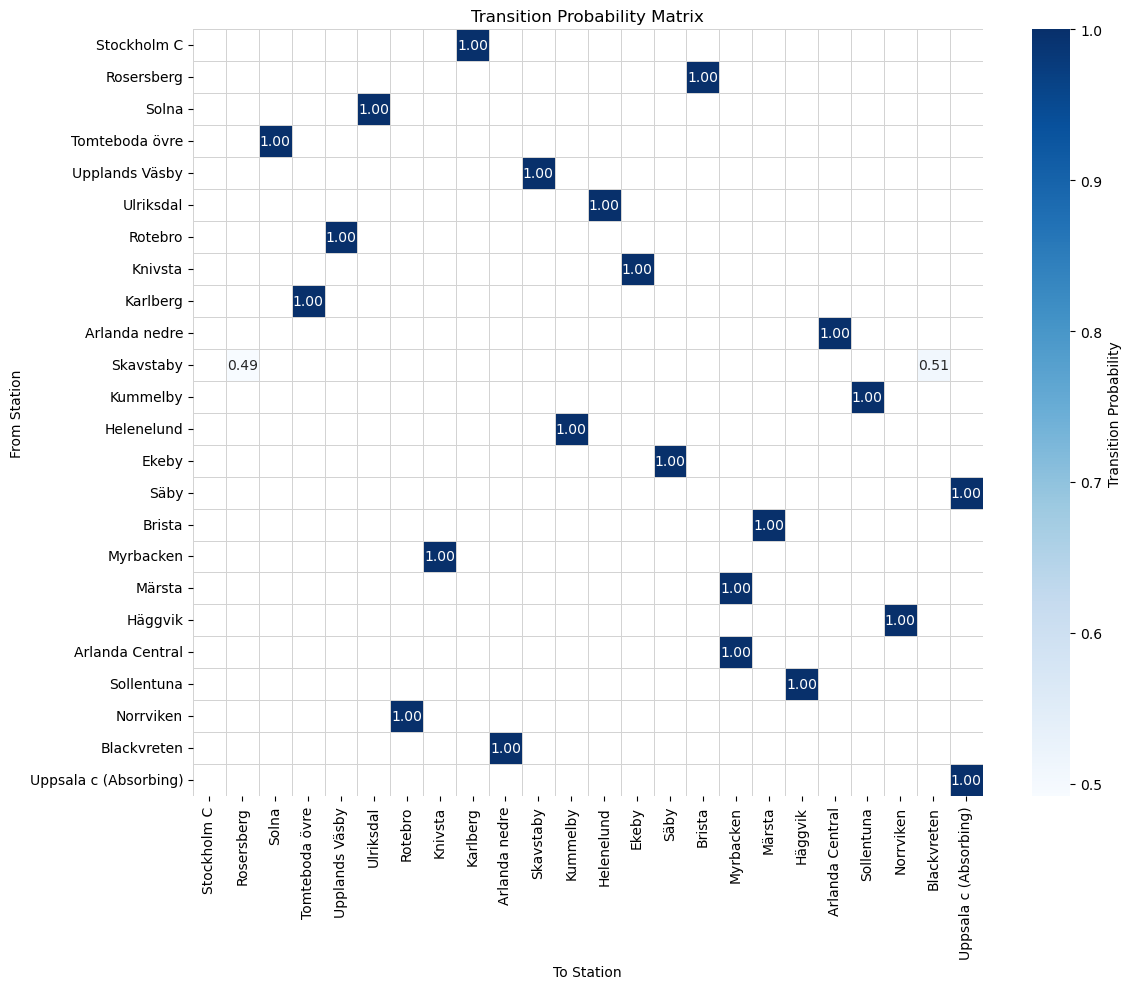

In [48]:
transition_probabilities=randomized_shortest_path_akamatsu(cost_matrix, 0, 23, 0.01)
df_transition= pd.DataFrame(transition_probabilities)
df_transition.columns = all_stations + [destination]
df_transition.index = all_stations + [destination]
df_transition = df_transition.rename(index={destination: destination + ' (Absorbing)'})
df_transition = df_transition.rename(columns={destination: destination + ' (Absorbing)'})

df_transition = df_transition.replace(0, np.nan)  # Replace 0 with NaN for better visualization
plt.figure(figsize=(12, 10))

sns.heatmap(df_transition, cmap='Blues', annot=True, fmt=".2f",
            linewidths=0.5, linecolor='lightgray', cbar_kws={'label': 'Transition Probability'})

plt.title('Transition Probability Matrix')
plt.xlabel('To Station')    
plt.ylabel('From Station')
plt.xticks(rotation=90)
plt.yticks(rotation=0)  
plt.tight_layout()
plt.show()
